# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'1.0.0'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())
df2.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model,Standard
0,M58_c25_a1_FIA,103.311660,0.008278,1285.589889,0.007873,261.694607,1285.589889,452.600940,0.643842,2.933874,...,1.075875,0.016943,0.004921,1.244898,1.263291,0.251991,0.002062,PseudoVoigtModel,PseudoVoigtModel,No
1,M58_c1_a1_FIA,103.495221,0.011060,1285.144056,0.010243,224.827572,1285.144056,467.934877,0.753654,2.802763,...,1.059308,0.023710,0.006704,1.079890,1.007921,0.098193,0.002833,PseudoVoigtModel,PseudoVoigtModel,No
2,M58_c1_a2_FIB,103.346417,0.011401,1285.538872,0.010543,207.453988,1285.538872,397.086025,0.749439,2.920985,...,1.051370,0.050524,0.007225,1.236760,1.234483,0.269120,0.002777,PseudoVoigtModel,PseudoVoigtModel,No
3,M58_c6_a1_FIB,103.378278,0.036769,1285.444391,0.033852,47.497043,1285.444391,75.260119,0.744280,2.034478,...,1.495781,0.564626,0.031340,1.213213,1.207207,0.243507,0.011191,PseudoVoigtModel,PseudoVoigtModel,No
4,M58_c10_a1_FIA,103.299192,0.021047,1285.599922,0.018725,168.031728,1285.599922,324.337076,0.757002,4.424063,...,1.167260,0.125297,0.009010,1.304762,1.354691,0.339707,0.003358,PseudoVoigtModel,PseudoVoigtModel,No


## First, get the metadata for this day

In [4]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=meta_file_ext, exclude_str=['Ne', 'Cap','window'],
 sort=True)
diad_meta[0]

'01 FG04_A1_4.txt'

## Now get all the important information out of the metadata files

In [5]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=str_prefix,
trupower=TruPower)
meta.head()

100%|██████████| 55/55 [00:00<00:00, 198.13it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,FG04_A1_4_start.txt,"July 2, 2024\n",July,2.0,6.095,45.0,5.0,50.0,"['0h', '3m', '46s']",10:14:19 AM\n,36859.0,1324.964
1,M58_c26_a1_FIA_crazySO2.txt,"July 2, 2024\n",July,2.0,6.027,45.0,3.0,50.0,"['0h', '2m', '44s']",10:27:17 AM\n,37637.0,1324.964
2,M58_c25_a1_FIA.txt,"July 2, 2024\n",July,2.0,10.025,60.0,4.0,50.0,"['0h', '4m', '1s']",10:45:16 AM\n,38716.0,1324.964
3,M58_c1_a1_FIA.txt,"July 2, 2024\n",July,2.0,9.998,60.0,4.0,50.0,"['0h', '4m', '1s']",10:54:46 AM\n,39286.0,1324.964
4,M58_c1_a2_FIB.txt,"July 2, 2024\n",July,2.0,9.939,60.0,4.0,50.0,"['0h', '4m', '1s']",11:00:41 AM\n,39641.0,1324.964


## Then get a simple file name you can stitch with the spectra

In [6]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=meta_file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'FG04_A1_4_start'

## Now get filename from spectra into same form as metadata

In [7]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=spectra_file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
M58_c25_a1_FIA


In [8]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,M58_c25_a1_FIA,103.311660,0.008278,1285.589889,0.007873,261.694607,1285.589889,452.600940,0.643842,2.933874,...,July,2.0,10.025,60.0,4.0,50.0,"['0h', '4m', '1s']",10:45:16 AM\n,38716.0,1324.964
1,M58_c1_a1_FIA,103.495221,0.011060,1285.144056,0.010243,224.827572,1285.144056,467.934877,0.753654,2.802763,...,July,2.0,9.998,60.0,4.0,50.0,"['0h', '4m', '1s']",10:54:46 AM\n,39286.0,1324.964
2,M58_c1_a2_FIB,103.346417,0.011401,1285.538872,0.010543,207.453988,1285.538872,397.086025,0.749439,2.920985,...,July,2.0,9.939,60.0,4.0,50.0,"['0h', '4m', '1s']",11:00:41 AM\n,39641.0,1324.964
3,M58_c6_a1_FIB,103.378278,0.036769,1285.444391,0.033852,47.497043,1285.444391,75.260119,0.744280,2.034478,...,July,2.0,10.057,60.0,4.0,50.0,"['0h', '4m', '1s']",12:26:51 PM\n,44811.0,1324.964
4,M58_c10_a1_FIA,103.299192,0.021047,1285.599922,0.018725,168.031728,1285.599922,324.337076,0.757002,4.424063,...,July,2.0,9.991,60.0,4.0,50.0,"['0h', '4m', '1s']",1:08:07 PM\n,47287.0,1324.964


## If you have secondary phases, now is the time to merge those in

In [9]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=str_prefix, file_ext=spectra_file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

Made a df!
good job, no duplicate file names


## If you have SO2, now is the time to calculate the molar proportion of SO2

In [10]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    

        SO2_mol_ratio=pf.calculate_SO2_CO2_ratio(SO2_area=df_combo_sec_phase['Peak_Area_SO2'], 
        diad1_area=df_combo_sec_phase['Diad1_Voigt_Area'], diad2_area=df_combo_sec_phase['Diad2_Voigt_Area'], 
                SO2_cross_sec=5.3, diad1_cross_sec=0.89, diad2_cross_sec=1.4)
        

        df_combo_sec_phase['SO2_mol_ratio']=SO2_mol_ratio

## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [11]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

5.950238906593519e-06


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,M58_c25_a1_FIA,0.138967,0.005074,0.003283,0.003868,103.100969,0.008286,0.000632,0.008278,10.025,...,1151.008207,67.116493,46.950902,Spline,0.058511,0.024658,38716.0,0.997961,0.997955,0.997967
1,M58_c1_a1_FIA,0.216730,0.005127,0.004550,0.002364,103.284031,0.011055,0.000628,0.011060,9.998,...,NaN,NaN,NaN,NaN,NaN,NaN,39286.0,0.997959,0.997953,0.997965
2,M58_c1_a2_FIB,0.152624,0.005972,0.004515,0.003908,103.135435,0.011395,0.000624,0.011401,9.939,...,NaN,NaN,NaN,NaN,NaN,NaN,39641.0,0.997958,0.997952,0.997965
3,M58_c6_a1_FIB,0.164215,0.015068,0.014541,0.003949,103.164687,0.036698,0.000597,0.036769,10.057,...,NaN,NaN,NaN,NaN,NaN,NaN,44811.0,0.997934,0.997928,0.997940
4,M58_c10_a1_FIA,0.132308,0.009174,0.008326,0.003852,103.084165,0.021012,0.000593,0.021047,9.991,...,NaN,NaN,NaN,NaN,NaN,NaN,47287.0,0.997918,0.997913,0.997924


In [12]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

5.950238906593519e-06


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,M58_c25_a1_FIA,0.138967,0.005074,0.003283,0.003868,103.100969,0.008286,0.000632,0.008278,10.025,...,1151.008207,67.116493,46.950902,Spline,0.058511,0.024658,38716.0,0.997961,0.997955,0.997967
1,M58_c1_a1_FIA,0.216730,0.005127,0.004550,0.002364,103.284031,0.011055,0.000628,0.011060,9.998,...,NaN,NaN,NaN,NaN,NaN,NaN,39286.0,0.997959,0.997953,0.997965
2,M58_c1_a2_FIB,0.152624,0.005972,0.004515,0.003908,103.135435,0.011395,0.000624,0.011401,9.939,...,NaN,NaN,NaN,NaN,NaN,NaN,39641.0,0.997958,0.997952,0.997965
3,M58_c6_a1_FIB,0.164215,0.015068,0.014541,0.003949,103.164687,0.036698,0.000597,0.036769,10.057,...,NaN,NaN,NaN,NaN,NaN,NaN,44811.0,0.997934,0.997928,0.997940
4,M58_c10_a1_FIA,0.132308,0.009174,0.008326,0.003852,103.084165,0.021012,0.000593,0.021047,9.991,...,NaN,NaN,NaN,NaN,NaN,NaN,47287.0,0.997918,0.997913,0.997924


### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [13]:

from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_July 2, 2024_fitted_2024-07-02.xlsx


## This helps visualize the errors on each spectra 

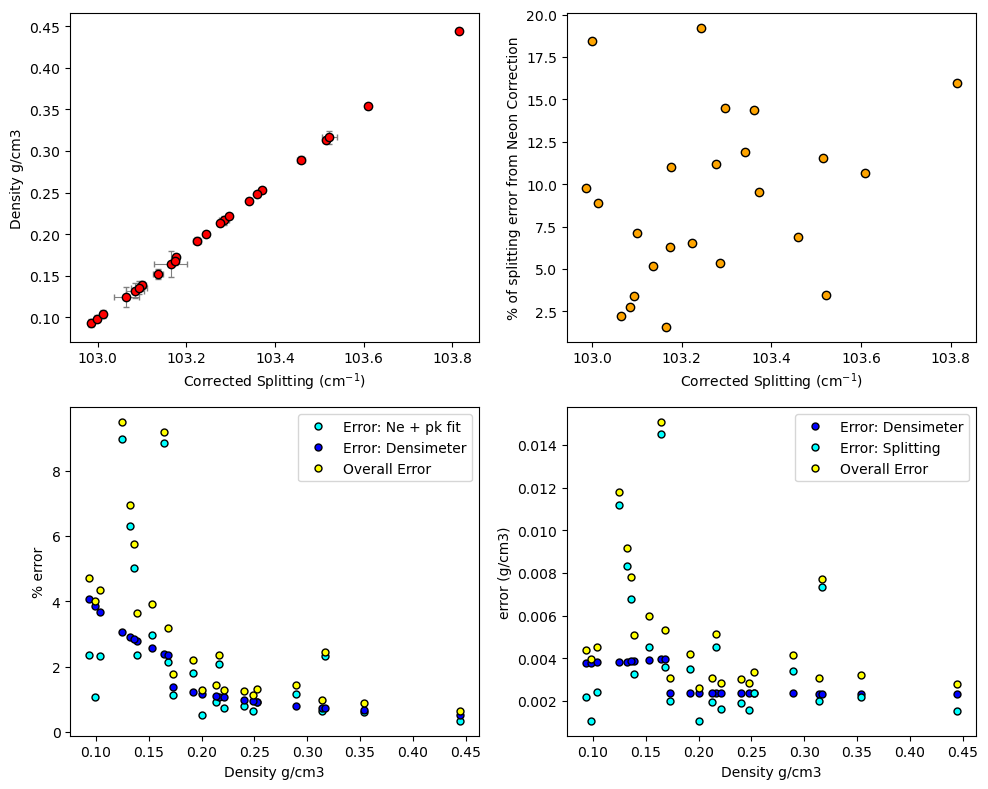

In [16]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=sorted_df.loc[(sorted_df['Density g/cm3']>0) & (sorted_df['Standard']!='Yes')]

ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## lets look at standards


Text(0, 0.5, 'Density g/cm3')

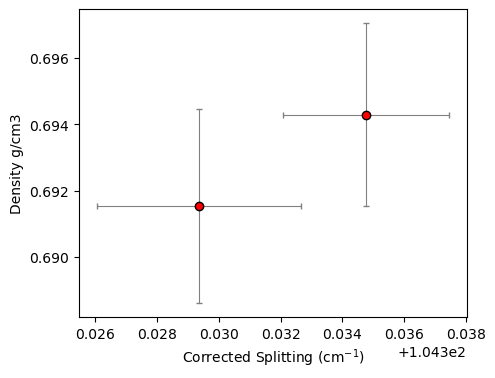

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df=sorted_df.loc[ sorted_df['Standard']=='Yes']
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

## If you were analysing fluid inclusions, lets calculate their pressures
- This bit isn't valid for melt inclusion vapour bubbles. 

Text(0, 0.5, '# of FI')

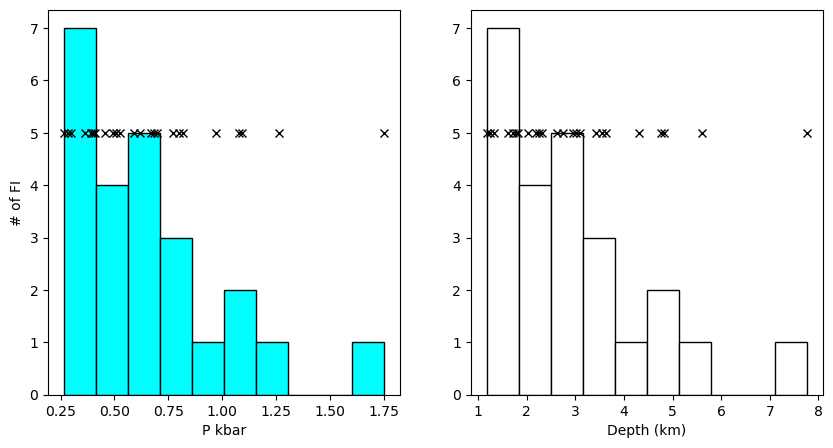

In [22]:
# Calculate pressure with a temperature estimate
Temp_C=1150
df=sorted_df.loc[(sorted_df['Density g/cm3']>0) & (sorted_df['Standard']!='Yes')]

Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SW96')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                crust_dens_kgm3=2300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')